## Load data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-paper')

function which install pip packages if they are not installed.
In this way we can import librosa

In [2]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package]) 

import_or_install("librosa")
import librosa

In [3]:
# from scipy.io import wavfile

# def load_data(phase, path = os.getcwd()):
#     if phase == "dev":
#         data_path = os.path.join("dsl_data", "development.csv")
#     elif phase == "eval":
#         data_path = os.path.join("dsl_data", "evaluation.csv")
#     else:
#         raise Exception(f"Error - phase '{phase}' not recognised.")

#     df = pd.read_csv(os.path.join(path, data_path), index_col=0)

#     rates = []
#     datas = []
#     for wav_path in df["path"]:
#         sample_rate, audio = wavfile.read(os.path.join(path, wav_path))
#         rates.append(sample_rate)
#         datas.append(audio)
#     df["rate"] = rates
#     df["data"] = datas

#     if phase == "dev":
#         df["intent"] = df["action"] + df["object"]
#         df.drop(columns=["action", "object"], inplace=True)
    
#     return df



def load_data(phase, path = os.getcwd()):
    if phase == "dev":
        data_path = os.path.join("dsl_data", "development.csv")
    elif phase == "eval":
        data_path = os.path.join("dsl_data", "evaluation.csv")
    else:
        raise Exception(f"Error - phase '{phase}' not recognised.")

    df = pd.read_csv(os.path.join(path, data_path), index_col=0)

    rates = []
    datas = []
    for wav_path in df["path"]:
        audio, sample_rate = librosa.load(os.path.join(path, wav_path), sr=None)
        rates.append(sample_rate)
        datas.append(audio)
    df["rate"] = rates
    df["data"] = datas

    if phase == "dev":
        df["intent"] = df["action"] + df["object"]
        df.drop(columns=["action", "object"], inplace=True)
    
    return df

In [4]:
df_dev  = load_data("dev")
df_eval = load_data("eval")

## Preprocessing

Exclusively for the preprocessing phase, we will concat the development and evaluation data set. In this way we can modify the variables only once and study the distribution of the data in more detail.

In [5]:
df = pd.concat([df_dev, df_eval], sort=False)
df_dev.shape, df_eval.shape, df.shape

((9854, 10), (1455, 9), (11309, 10))

check for missing values

In [6]:
pd.DataFrame({"Type": df.dtypes, "NaN": df.isna().any(axis=0)})

,Type,NaN
path,object,False
speakerId,object,False
Self-reported fluency level,object,False
First Language spoken,object,False
Current language used for work/school,object,False
gender,object,False
ageRange,object,False
rate,int64,False
data,object,False
intent,object,True


Just `intent`, but it is because `df_eval` does not have the label column

In [7]:
df[df.columns.drop("data")].nunique()

path                                     11309
speakerId                                   97
Self-reported fluency level                  4
First Language spoken                        5
Current language used for work/school        4
gender                                       2
ageRange                                     3
rate                                         2
intent                                       7
dtype: int64

Let's do some plots to study the distributions of the variables

<AxesSubplot: >

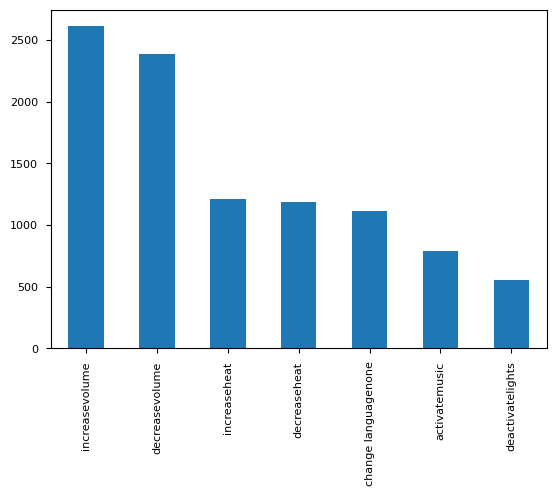

In [8]:
df["intent"].value_counts().plot.bar()

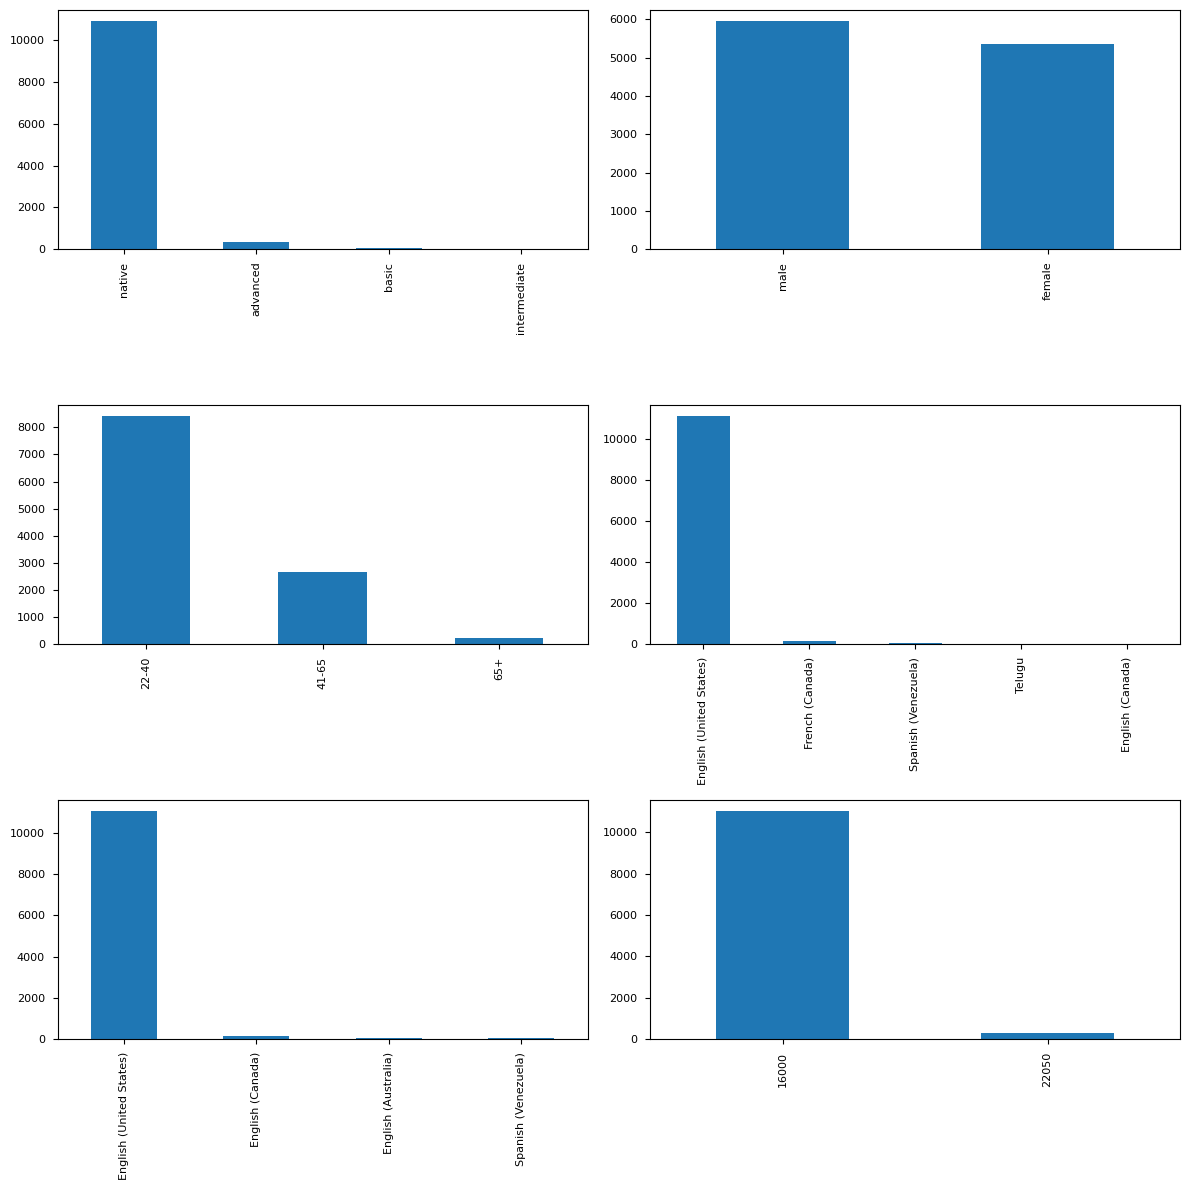

In [9]:
cols = ["Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange", "rate"]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, c in enumerate(cols):
    df[c].value_counts().plot.bar(ax=ax[i%3][i%2])
plt.tight_layout()
plt.show()

Note that the majority of the speakers are native english (united states). So we could gather the others all together.      

Moreover, there are two type of sample rates.   
The distribution of the length of data is the following

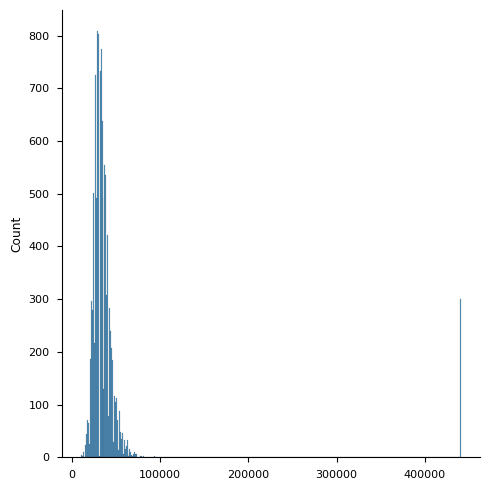

In [10]:
from seaborn import displot
displot([len(data) for data in df["data"]])

There is an outlier

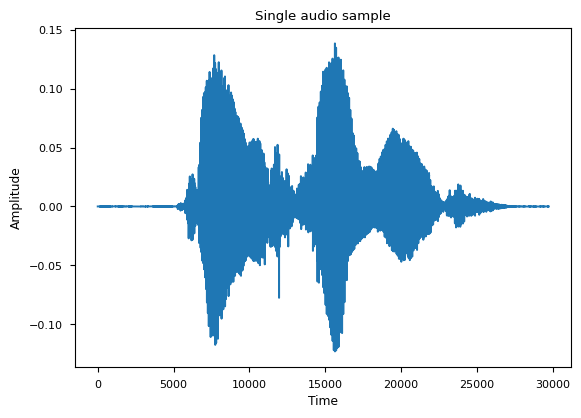

In [11]:
fig, ax = plt.subplots()
ax.plot(df_dev["data"][0]) # Plot the first signal
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.set_title("Single audio sample")
plt.show()

<AxesSubplot: >

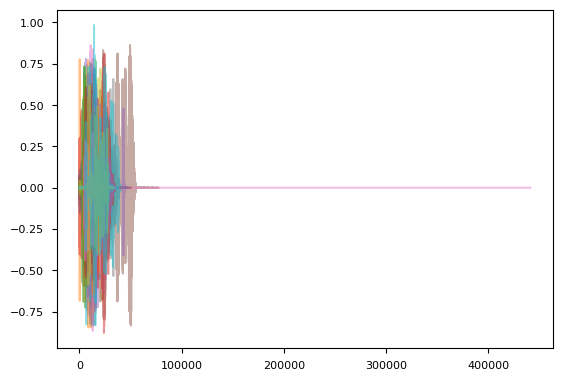

In [12]:
def plot_audio_samples(X, sample_rate):
    lengths = []
    fig, ax = plt.subplots()
    for idx in range(0, len(X), 250):
        ax.plot(X[idx], alpha=0.5)
        lengths.append(len(X[idx]))
    return ax

plot_audio_samples(df_dev["data"], df_dev["rate"][0])

512 is the suggested value for speech recognition

In [67]:
spectograms = [librosa.stft(data, n_fft=512) for data in df["data"]]
df["spectogram"] = spectograms

In [70]:
db_spectograms = [librosa.amplitude_to_db(abs(spec)) for spec in df["spectogram"]]
df["data_db"] = db_spectograms

MemoryError: Unable to allocate 490. KiB for an array with shape (257, 488) and data type float32

In [ ]:
librosa.display.specshow(df_dev["data_db"][0], sr=df_dev["rate"][0], x_axis="time", y_axis="hz")
plt.colorbar()